# LIBRARIES

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.image as img
%matplotlib inline

# DATA LOAD

In [2]:
!pip install split-folders
import splitfolders
splitfolders.ratio('../input/alzheimer-mri-dataset/Dataset', output="output", seed=1345, ratio=(.8, 0.1,0.1)) 

Copying files: 6400 files [01:47, 59.27 files/s]


In [3]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/train",
seed=123, label_mode='categorical',
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/test",
seed=123,label_mode='categorical',
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/val",
seed=123,label_mode='categorical',
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

Found 5119 files belonging to 4 classes.
Found 642 files belonging to 4 classes.
Found 639 files belonging to 4 classes.


In [4]:
class_names = train_ds.class_names
print(class_names)
train_ds

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

# EXAMPLE IMAGE

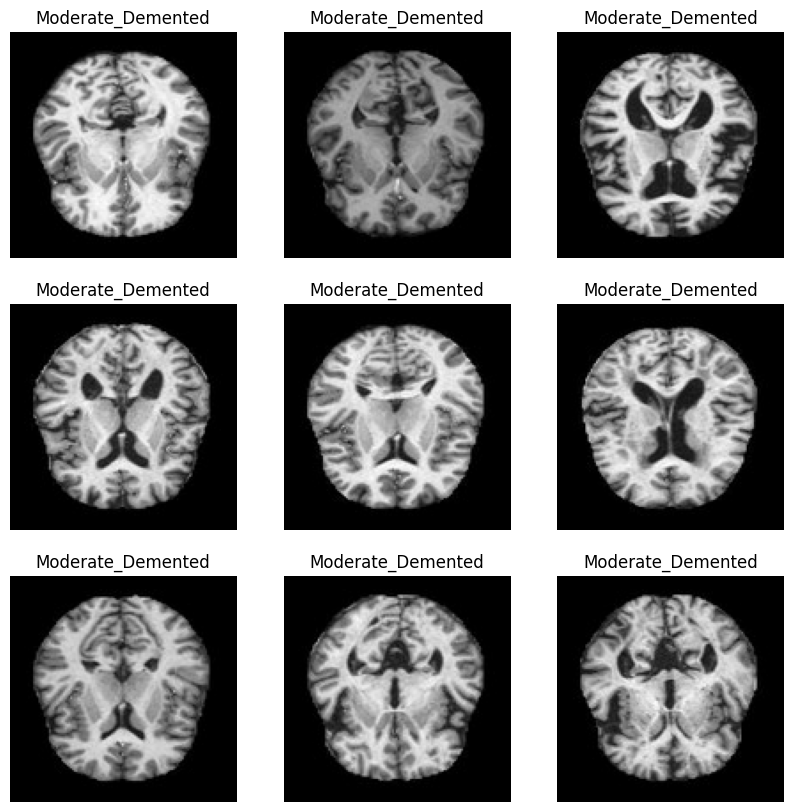

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(max(labels[i]))])
        plt.axis("off")
        
        


<function matplotlib.pyplot.show(close=None, block=None)>

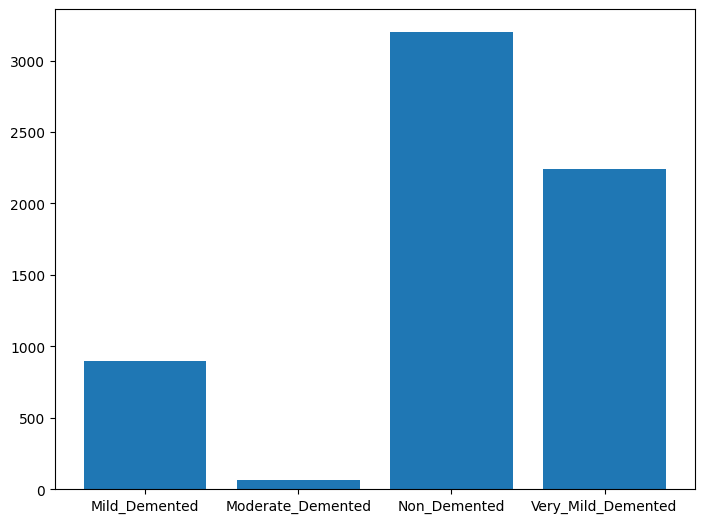

In [6]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [896,64,3200,2240]
ax.bar(class_names,size)
plt.show

# MODEL

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(32,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

c:\Users\avani\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
model.compile(loss="categorical_crossentropy",
              optimizer = "Adam",metrics=['accuracy',
                                tf.keras.metrics.AUC(),
                                tf.keras.metrics.Precision(),
                                tf.keras.metrics.Recall(),])

In [11]:
filepath = './cnn_best_weights.keras'
earlystopping=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              mode='max',
                                              patience=10,
                                              verbose=1)
checkpoint= tf.keras.callbacks.ModelCheckpoint(filepath,
                           monitor='val_accuracy',
                           mode='max',
                           save_best_only=True,
                           verbose=1)

callbacks_list=[earlystopping,checkpoint]

In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,125,124 (8.11 MB)

 Trainable params: 2,125,124 (8.11 MB)

 Non-trainable params: 0 (0.00 B)

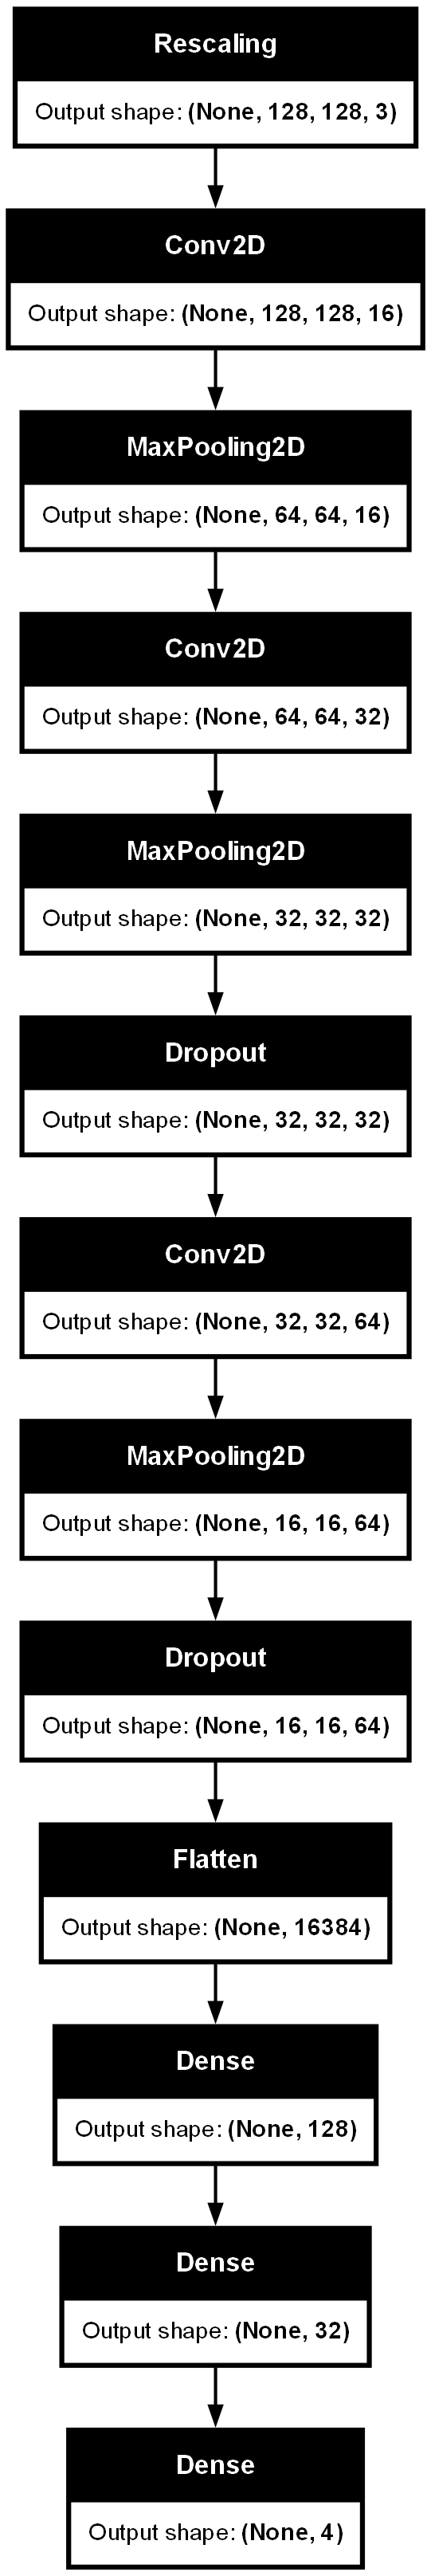

In [13]:
tf.keras.utils.plot_model(model,show_shapes=True,dpi=150)

In [15]:
hist = model.fit(train_ds,validation_data=val_ds,epochs=50, batch_size=64, verbose=1,
                 callbacks= callbacks_list)

Epoch 1/50


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.4533 - auc: 0.6998 - loss: 2.6358 - precision: 0.4660 - recall: 0.3336
Epoch 1: val_accuracy improved from -inf to 0.50078, saving model to ./cnn_best_weights.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 253ms/step - accuracy: 0.4537 - auc: 0.7005 - loss: 2.6225 - precision: 0.4666 - recall: 0.3336 - val_accuracy: 0.5008 - val_auc: 0.8292 - val_loss: 1.0450 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.5193 - auc: 0.8145 - loss: 0.9868 - precision: 0.6173 - recall: 0.3638
Epoch 2: val_accuracy improved from 0.50078 to 0.61189, saving model to ./cnn_best_weights.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - accuracy: 0.5193 - auc: 0.8146 - loss: 0.9867 - precision: 0.6175 - recall: 0.3637 - val_accuracy: 0.6119 - val_auc: 0.8624 - val_loss: 0.9847 - val_precision: 0.8958 - val_recall: 0.2019
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.5684 - a

# Plot the result


In [16]:
result = model.evaluate(test_ds)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Test Loss = {train_loss}')
print(f'Test Accuracy = {train_accuracy}')
print(f'Test AUC = {train_AUC}')
print(f'Test Precision = {train_pre}')
print(f'Test Recall = {train_rec}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9886 - auc: 0.9999 - loss: 0.0293 - precision: 0.9886 - recall: 0.9878
Test Loss = 0.030311526730656624
Test Accuracy = 0.9875389337539673
Test AUC = 0.9998434782028198
Test Precision = 0.9875195026397705
Test Recall = 0.985981285572052


In [19]:
get_ac = hist.history['accuracy']
get_los = hist.history['loss']
get_pre = hist.history['precision']
get_rec = hist.history['recall']
get_auc = hist.history['auc']

val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

<Figure size 640x480 with 0 Axes>

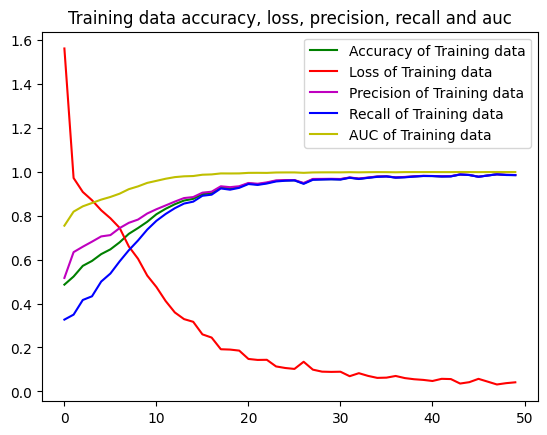

<Figure size 640x480 with 0 Axes>

In [20]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.plot(epochs, get_pre, 'm', label='Precision of Training data')
plt.plot(epochs, get_rec, 'b', label='Recall of Training data')
plt.plot(epochs, get_auc, 'y', label='AUC of Training data')

plt.title('Training data accuracy, loss, precision, recall and auc')
plt.legend(loc=0)
plt.figure()

# plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
# plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
# plt.title('Training and Validation Accuracy')
# plt.legend(loc=0)
# plt.figure()

# plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
# plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
# plt.title('Training and Validation Loss')
# plt.legend(loc=0)
# plt.figure()
# plt.show()

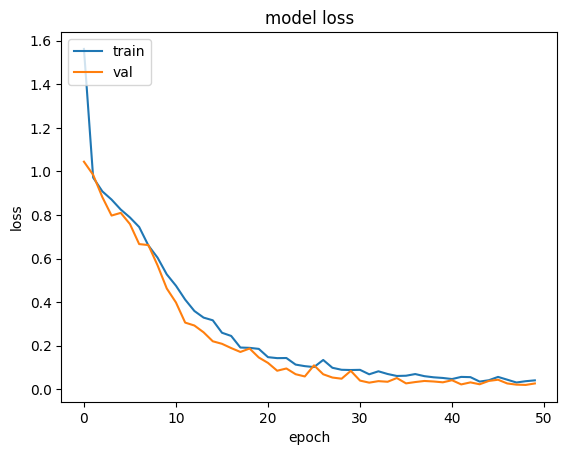

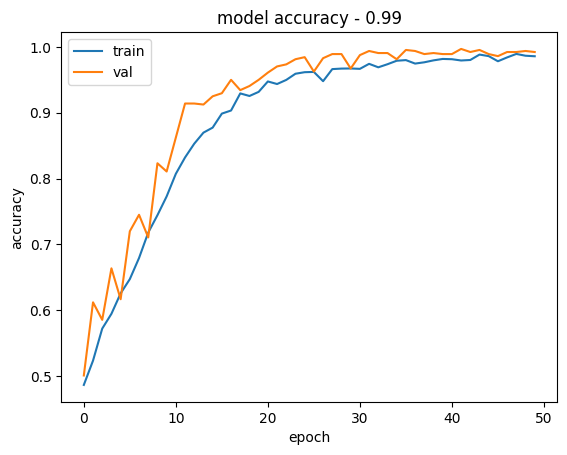

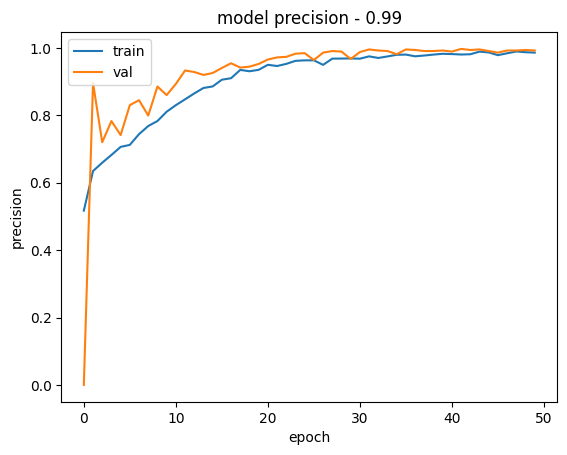

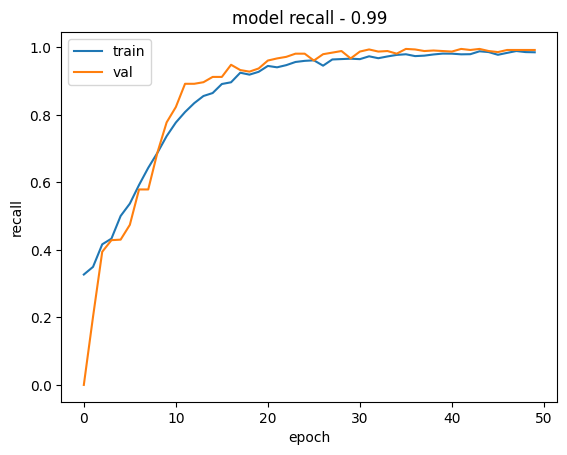

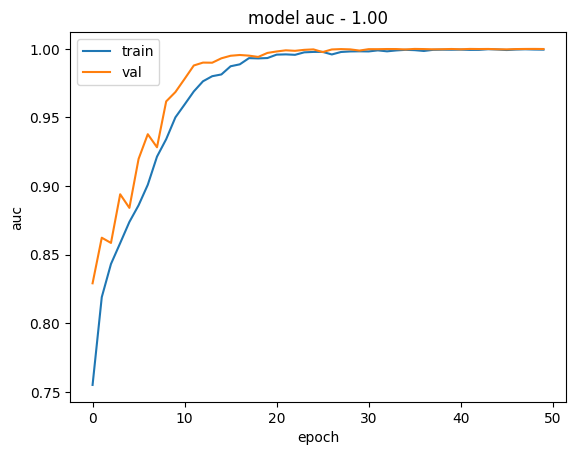

In [22]:
# loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy - ' + str(format(result[1], "0.2f")))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Precision
plt.plot(hist.history['precision'])
plt.plot(hist.history['val_precision'])
plt.title('model precision - ' + str(format(result[3], "0.2f")))
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Recall
plt.plot(hist.history['recall'])
plt.plot(hist.history['val_recall'])
plt.title('model recall - ' + str(format(result[4], "0.2f")))
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# AUC
plt.plot(hist.history['auc'])
plt.plot(hist.history['val_auc'])
plt.title('model auc - ' + str(format(result[2], "0.2f")))
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Confusion Matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


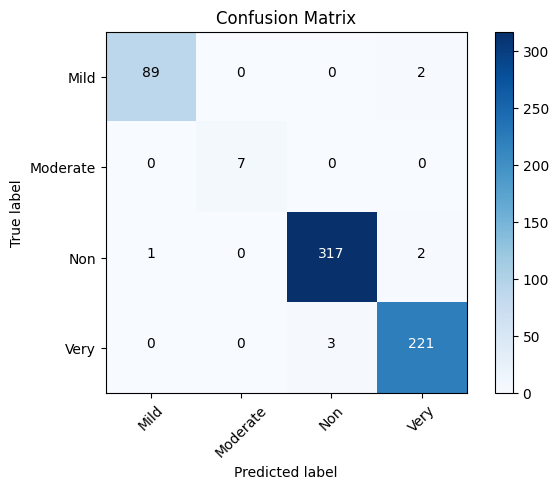

In [23]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from itertools import product
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)
correct_labels = np.argmax(correct_labels,axis=1)
confusion_mtx = confusion_matrix(correct_labels, predicted_labels)

# Define the class labels
class_names = ['Mild', 'Moderate', 'Non', 'Very']

# Plot the confusion matrix
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
fmt = 'd'
thresh = confusion_mtx.max() / 2.
for i, j in product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
    plt.text(j, i, format(confusion_mtx[i, j], fmt),
             horizontalalignment="center",
             color="white" if confusion_mtx[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()